# Chuẩn bị môi trường và phân tích tổng quát

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
X_mse = pd.read_csv('/home/windyday/DSproject/data/X_mse.csv')

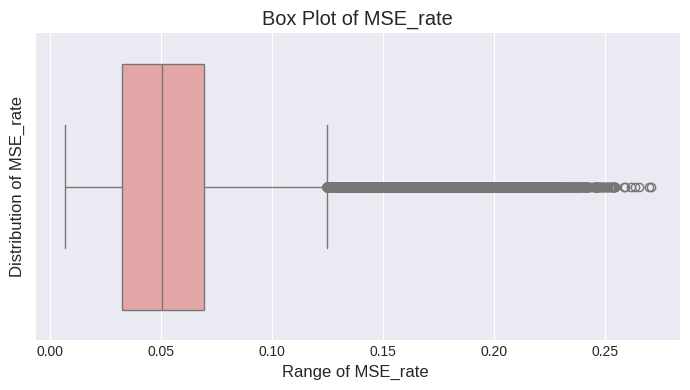

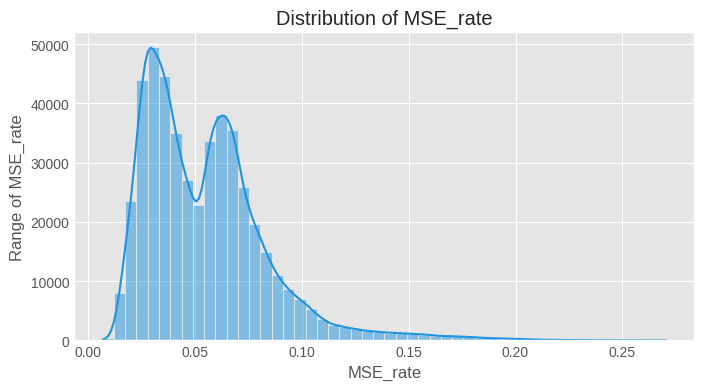

In [142]:
def boxplot_drawing(dataframe: object, 
                    column_name: str, 
                    log_scale=None) -> object:
    plt.figure(figsize=(7, 4))
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.boxplot(x=dataframe[column_name], 
                color= '#ED9C9C', 
                log_scale=log_scale)
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(f'Range of {column_name} ')
    plt.ylabel(f'Distribution of {column_name}')
    plt.tight_layout()
    plt.show()

def histplot_drawing(dataframe: object, 
                     column_name: str, 
                     bins='auto', 
                     log_scale=None) -> object:
    plt.figure(figsize=(8, 4))
    plt.style.use('ggplot')
    sns.histplot(data=dataframe, 
                 x=column_name, 
                 bins=bins, 
                 color='#2093DF', 
                 kde=True, 
                 log_scale=log_scale)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel(f'Range of {column_name}')
    plt.show()
    
boxplot_drawing(X_mse, 'MSE_rate')
histplot_drawing(X_mse, 'MSE_rate', bins=50)

In [54]:
print(f"Percentage of anomaly from thresholding: {(len(X_mse[X_mse['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)]) / len(X_mse))*100:.2f}%")

Percentage of anomaly from thresholding: 2.00%


In [8]:
X_train_mse_features['MSE_rate'].quantile(0.99)

np.float64(0.16913671670000002)

In [146]:
len(X_mse[X_mse['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])

9557

# Áp Dụng Isolation Forest

## Chuẩn bị dữ liệu

In [6]:
dataset_total_len = len(X_mse)
train_end_idx = int(dataset_total_len * 0.7)
validation_end_idx = int(dataset_total_len * 0.85)

X_train_mse_features = pd.DataFrame(X_mse.iloc[:train_end_idx])
X_validate_mse_features = pd.DataFrame(X_mse.iloc[train_end_idx:validation_end_idx])
X_test_mse_features = pd.DataFrame(X_mse.iloc[validation_end_idx:])

print(f"Training set: {X_train_mse_features.shape}")
print(f"Testing set: {X_validate_mse_features.shape}")
print(f"Validating set: {X_test_mse_features.shape}")

Training set: (334480, 50)
Testing set: (71674, 50)
Validating set: (71675, 50)


## Huấn luyện mô hình

In [168]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(
    n_estimators=700, 
    contamination=0.022, 
    random_state=42
)

isolation_forest.fit(X_train_mse_features)

train_predictions = isolation_forest.predict(X_train_mse_features)
train_anomaly_scores = isolation_forest.decision_function(X_train_mse_features)
train_fraud_labels = (train_predictions == -1).astype(int)

validate_predictions = isolation_forest.predict(X_validate_mse_features)
validate_anomaly_scores = isolation_forest.decision_function(X_validate_mse_features)
validate_fraud_labels = (validate_predictions == -1).astype(int)

## Kiểm thử bằng tập Validate (Hyperparameter tuning)

In [167]:
forest_results = pd.concat([pd.DataFrame(validate_predictions, columns=['predict']), 
                            pd.DataFrame(validate_anomaly_scores, columns=['anomaly_score']),
                            pd.DataFrame(validate_fraud_labels, columns=['is_fraud'])], axis=1)
comparison_feature = X_validate_mse_features.reset_index(drop=True)
validate_forest = pd.concat([comparison_feature, forest_results], axis=1)
validate_forest['label'] = (validate_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)).astype(int)

print(f"Total anomalies: {len(validate_forest[validate_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])}")
print(f"Total anomalies predictions made by model: {len(validate_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(validate_forest.query('is_fraud == 1 and MSE_rate > 0.138881922'))}")

Total anomalies: 505
Total anomalies predictions made by model: 3771
Actual anomalies correctly identified: 424


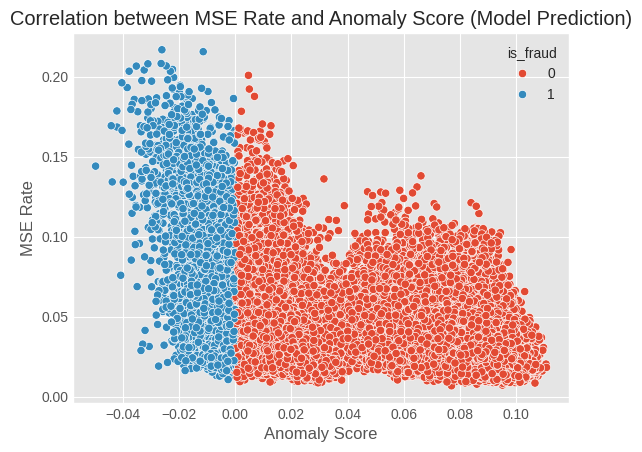

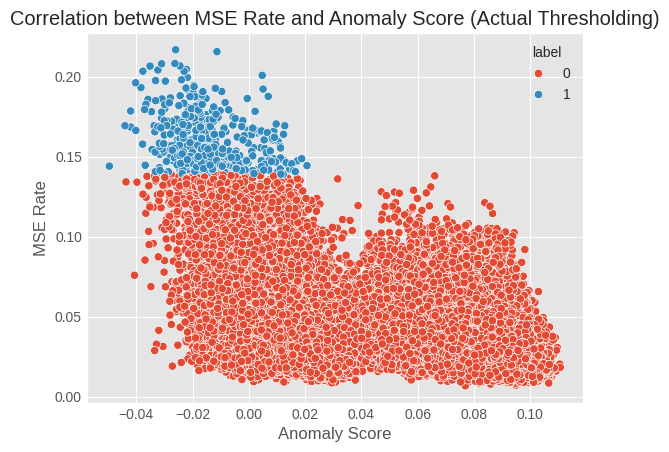

In [159]:
plt.style.use('ggplot')
sns.scatterplot(x=validate_forest['anomaly_score'], y=validate_forest['MSE_rate'], data=validate_forest, hue=validate_forest['is_fraud'])
plt.title('Correlation between MSE Rate and Anomaly Score (Model Prediction)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

plt.style.use('ggplot')
sns.scatterplot(x=validate_forest['anomaly_score'], y=validate_forest['MSE_rate'], data=validate_forest, hue=validate_forest['label'])
plt.title('Correlation between MSE Rate and Anomaly Score (Actual Thresholding)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

## Tái kiểm thử bằng dữ liệu còn lại (tập Test)

In [161]:
test_predictions = isolation_forest.predict(X_test_mse_features)
test_anomaly_scores = isolation_forest.decision_function(X_test_mse_features)
test_fraud_labels = (test_predictions == -1).astype(int)

forest_results = pd.concat([pd.DataFrame(test_predictions, columns=['predict']), 
                            pd.DataFrame(test_anomaly_scores, columns=['anomaly_score']),
                            pd.DataFrame(test_fraud_labels, columns=['is_fraud'])], axis=1)

comparison_feature = X_test_mse_features.reset_index(drop=True)
test_forest = pd.concat([comparison_feature, forest_results], axis=1)
test_forest['label'] = (test_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)).astype(int)

print(f"Total anomalies: {len(test_forest[test_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.98)])}")
print(f"Total anomalies predictions made by model: {len(test_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(test_forest.query('is_fraud == 1 and MSE_rate > 0.138881922'))}")

Total anomalies: 475
Total anomalies predictions made by model: 3632
Actual anomalies correctly identified: 394


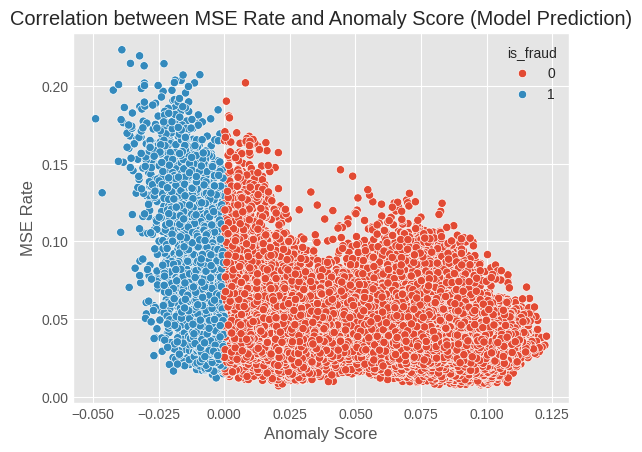

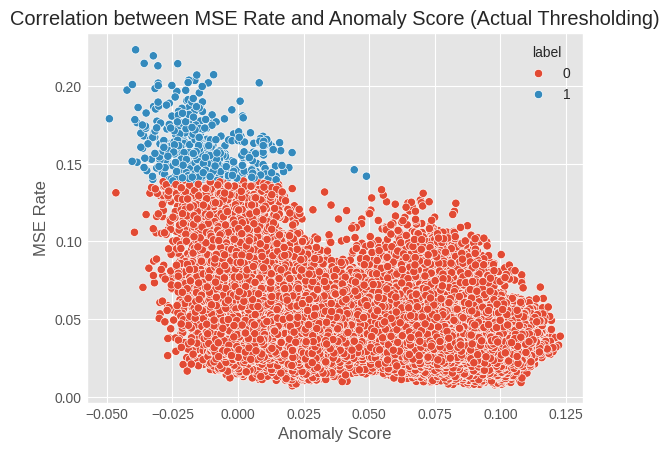

In [162]:
plt.style.use('ggplot')
sns.scatterplot(x=test_forest['anomaly_score'], y=test_forest['MSE_rate'], data=test_forest, hue=test_forest['is_fraud'])
plt.title('Correlation between MSE Rate and Anomaly Score (Model Prediction)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

plt.style.use('ggplot')
sns.scatterplot(x=test_forest['anomaly_score'], y=test_forest['MSE_rate'], data=test_forest, hue=test_forest['label'])
plt.title('Correlation between MSE Rate and Anomaly Score (Actual Thresholding)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

# Tạo Anomaly Score cho toàn tập dữ liệu

In [163]:
total_predictions = isolation_forest.predict(X_mse)
total_anomaly_scores = isolation_forest.decision_function(X_mse)
total_fraud_labels = (total_predictions == -1).astype(int)

In [165]:
total_forest_results = pd.concat([
    pd.DataFrame(total_predictions, columns=['predict']), 
    pd.DataFrame(total_anomaly_scores, columns=['anomaly_score']),
    pd.DataFrame(total_fraud_labels, columns=['is_fraud'])
], axis=1)

total_comparison_feature = X_mse.reset_index(drop=True)
total_forest = pd.concat([total_comparison_feature, total_forest_results], axis=1)
total_forest['label'] = (total_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.99)).astype(int)

print(f"Total anomalies: {len(total_forest[total_forest['MSE_rate'] > X_mse['MSE_rate'].quantile(0.99)])}")
print(f"Total anomalies predictions made by model: {len(total_forest.query('is_fraud == 1'))}")
print(f"Actual anomalies correctly identified: {len(total_forest.query('is_fraud == 1 and MSE_rate > 0.16087847079999987'))}")

Total anomalies: 4779
Total anomalies predictions made by model: 14852
Actual anomalies correctly identified: 2855


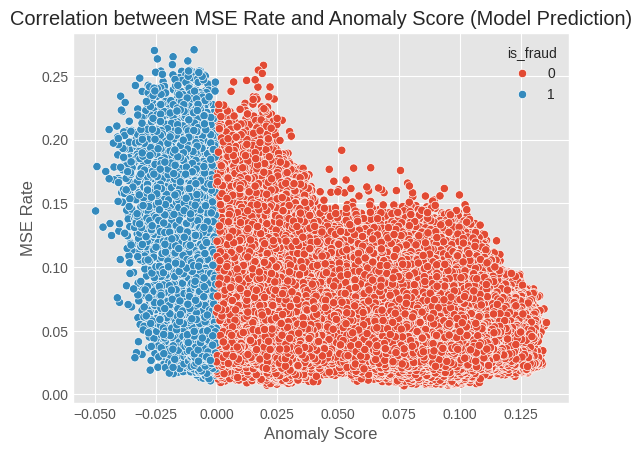

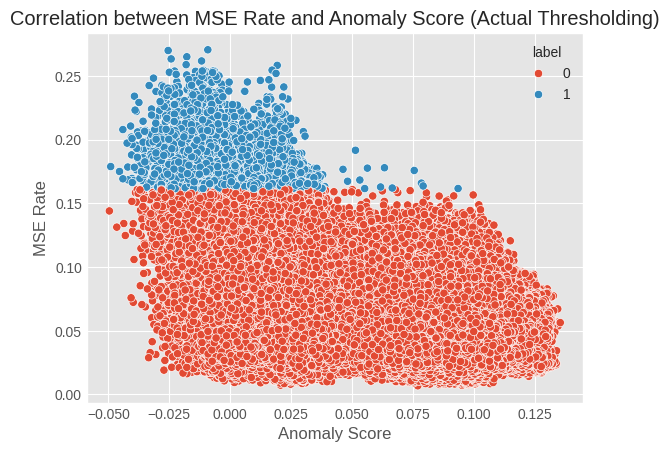

In [169]:
plt.style.use('ggplot')
sns.scatterplot(x=total_forest['anomaly_score'], y=total_forest['MSE_rate'], data=total_forest, hue=total_forest['is_fraud'])
plt.title('Correlation between MSE Rate and Anomaly Score (Model Prediction)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

plt.style.use('ggplot')
sns.scatterplot(x=total_forest['anomaly_score'], y=total_forest['MSE_rate'], data=total_forest, hue=total_forest['label'])
plt.title('Correlation between MSE Rate and Anomaly Score (Actual Thresholding)')
plt.xlabel('Anomaly Score')
plt.ylabel('MSE Rate')
plt.show()

# Tạo nhãn

In [ ]:
X_features = pd.concat([X_mse, pd.DataFrame(total_anomaly_scores, columns=['anomaly_score']), pd.DataFrame(total_fraud_labels, columns=['is_fraud'])], axis=1)

In [171]:
X_features['is_fraud'].value_counts()

is_fraud
0    462977
1     14852
Name: count, dtype: int64

In [11]:
# Tính ngưỡng trên TRAIN
mse_thresh = X_train_mse_features["MSE_rate"].quantile(0.99)

In [12]:
score_thresh = X_train_mse_features["anomaly_score"].quantile(0.98)

KeyError: 'anomaly_score'

In [ ]:
# Gán nhãn trên từng tập bằng ngưỡng từ train
def make_labels(df, mse_t=mse_thresh, score_t=score_thresh):
    return (
        (df["MSE_rate"] > mse_t) |
        ((df["is_fraud"] == 1) & (df["anomaly_score"] > score_t))
    ).astype(int)

y_train = make_labels(X_train)
y_valid = make_labels(X_validate)
y_test  = make_labels(X_test)

X_features.drop('is_fraud', axis=1, inplace=True)

KeyError: "['is_fraud'] not found in axis"

In [192]:
dataset_total_len = len(X_features)
train_end_idx = int(dataset_total_len * 0.7)
validation_end_idx = int(dataset_total_len * 0.85)

X_train = pd.DataFrame(X_features.iloc[:train_end_idx])
X_validate = pd.DataFrame(X_features.iloc[train_end_idx:validation_end_idx])
X_test = pd.DataFrame(X_features.iloc[validation_end_idx:])

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_validate.shape}")
print(f"Validating set: {X_test.shape}")

Training set: (334480, 51)
Testing set: (71674, 51)
Validating set: (71675, 51)


# Chạy nhanh XGBoost

In [176]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    average_precision_score, 
    classification_report
)

In [193]:
positive = sum(y_train == 1)
negative = sum(y_train == 0)
scale = negative / positive

In [194]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=350,
    subsample=0.9,
    scale_pos_weight=scale,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="aucpr"
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [196]:
y_pred_validate = model.predict(X_validate)
y_pred_proba_validate = model.predict_proba(X_validate)[:, 1]

print(f"Accuracy (reference only): {accuracy_score(y_valid, y_pred_validate)}")
print(f"AUC-ROC Score: {roc_auc_score(y_valid, y_pred_proba_validate)}")
print(f"Average Precision Score: {average_precision_score(y_valid, y_pred_proba_validate)}\n")
print("===================== Classification Report =====================\n")
print(classification_report(y_valid, y_pred_validate))
print(f"Confusion Matrix:\n{confusion_matrix(y_valid, y_pred_validate)}")

Accuracy (reference only): 0.9994837737533834
AUC-ROC Score: 0.9999081559544921
Average Precision Score: 0.9456630423820832

===================== Classification Report =====================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71564
           1       0.75      1.00      0.86       110

    accuracy                           1.00     71674
   macro avg       0.87      1.00      0.93     71674
weighted avg       1.00      1.00      1.00     71674

Confusion Matrix:
[[71527    37]
 [    0   110]]


In [197]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

print(f"Accuracy (reference only): {accuracy_score(y_test, y_pred_test)}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba_test)}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred_proba_test)}\n")
print("===================== Classification Report =====================\n")
print(classification_report(y_test, y_pred_test))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_test)}")

Accuracy (reference only): 0.9995395884199512
AUC-ROC Score: 0.9999331691253487
Average Precision Score: 0.9585593956776518

===================== Classification Report =====================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71569
           1       0.76      1.00      0.87       106

    accuracy                           1.00     71675
   macro avg       0.88      1.00      0.93     71675
weighted avg       1.00      1.00      1.00     71675

Confusion Matrix:
[[71536    33]
 [    0   106]]


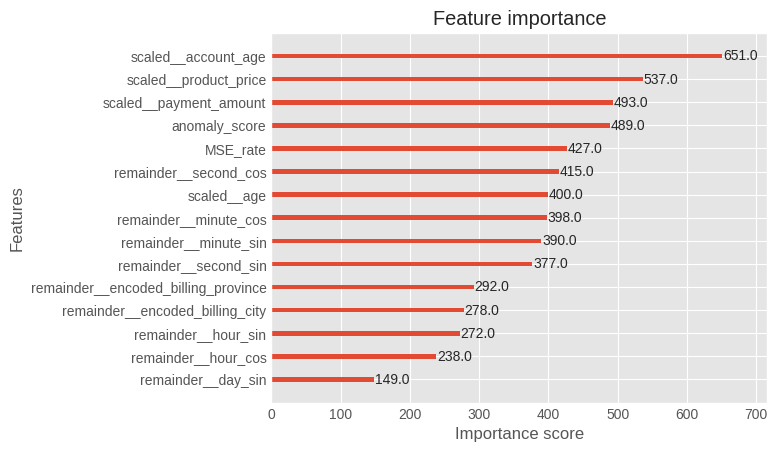

In [198]:
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [188]:
import joblib

joblib.dump(isolation_forest, "isolation_forest.joblib")

['isolation_forest.joblib']

In [200]:
model.save_model("xgboost_model.json")